# 1. 라이브러리 및 패키지 불러오기

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#2. 데이터 불러오기

In [29]:
log_data = pd.read_csv('/content/drive/MyDrive/2022_Bigcontest/Data/log_data.csv')
log = log_data

# 3. 전처리

##1) mp_os
- android os는 getcreditinfo행동밖에 없고, Android os는 getcreditinfo만 없으므로 합쳐주는게 맞다고 판단 android -> Android로 변환

- 애플 제품에는 login이 없음 / 아이패드에는 여윳돈 계산 기능이 없는것인지 하지 않은 것인지 암튼 없음

In [30]:
log.loc[list(log[log['mp_os']=='android'].index),'mp_os'] = 'Android'

In [31]:
log.loc[list(log[log['mp_os']=='iPadOS'].index),'mp_os'] = 'iOS'

In [32]:
# mp_os가 결측값이면 mp_app_version도 결측값임을 확인

## 2) timestamp

In [33]:
def extract_month(date):
    month = str(date.month)
    if date.month < 10:
        month = '0' + month
    return str(date.year) + month 

In [34]:
log['timestamp'] = pd.to_datetime(log['timestamp'], infer_datetime_format=True)

In [35]:
month_ = log.set_index('timestamp').groupby(extract_month)

# 3) 고객이탈

In [36]:
log.head()

,user_id,event,timestamp,mp_os,mp_app_version,date_cd
0,576409,StartLoanApply,2022-03-25 11:12:09,Android,3.8.2,2022-03-25
1,576409,ViewLoanApplyIntro,2022-03-25 11:12:09,Android,3.8.2,2022-03-25
2,72878,EndLoanApply,2022-03-25 11:14:44,Android,3.8.4,2022-03-25
3,645317,OpenApp,2022-03-25 11:15:09,iOS,3.6.1,2022-03-25
4,645317,UseLoanManage,2022-03-25 11:15:11,iOS,3.6.1,2022-03-25


In [62]:
funnel_dict = {'StartLoanApply' : 1, 'UseLoanManage': 2, 'UsePrepayCalc': 3, 'UseDSRCalc': 4, 'GetCreditInfo':5}
funnel_steps = pd.DataFrame.from_dict(funnel_dict, orient='index', columns=['step_no'])
funnel_steps

,step_no
StartLoanApply,1
UseLoanManage,2
UsePrepayCalc,3
UseDSRCalc,4
GetCreditInfo,5


In [91]:
grouped = log.groupby(['user_id', 'event'])['timestamp'].agg(np.min)
grouped = pd.DataFrame(grouped).merge(funnel_steps, left_on='event', right_index=True)
grouped.tail()

,,timestamp,step_no
user_id,event,,
878796,UseDSRCalc,2022-04-05 21:48:33,4
878870,UseDSRCalc,2022-04-22 18:54:29,4
879287,UseDSRCalc,2022-04-05 17:30:02,4
879399,UseDSRCalc,2022-03-03 18:20:50,4
879667,UseDSRCalc,2022-03-24 13:57:56,4


In [93]:
funnel = grouped.reset_index().pivot(index='user_id', columns='step_no', values='timestamp')
funnel.columns = funnel_steps.index
funnel

,StartLoanApply,UseLoanManage,UsePrepayCalc,UseDSRCalc,GetCreditInfo
user_id,,,,,
1,NaT,2022-06-16 23:58:41,NaT,NaT,2022-05-03 14:52:28
7,NaT,NaT,NaT,NaT,2022-05-22 16:39:49
9,NaT,NaT,NaT,NaT,2022-05-21 23:37:58
11,2022-03-24 10:55:43,2022-03-24 10:54:08,2022-03-24 10:54:36,NaT,2022-03-24 10:54:07
12,2022-03-14 01:13:21,2022-05-01 18:30:48,NaT,NaT,2022-05-01 18:30:42
...,...,...,...,...,...
879693,2022-05-13 11:29:49,2022-05-13 13:24:32,NaT,NaT,2022-05-13 13:24:33
879694,2022-03-31 20:07:23,NaT,NaT,NaT,NaT
879695,2022-05-27 12:48:32,NaT,NaT,NaT,NaT


In [94]:
step_values = [funnel[index].notnull().sum() for index in funnel_steps.index]
step_values

[326555, 297468, 4486, 3619, 462609]

In [95]:
def show_funnel(funnel_values, funnel_steps):
    from plotly import graph_objects as go
    
    fig = go.Figure(go.Funnel(
        y = funnel_steps,
        x = funnel_values
    ))
    
    fig.show()

In [96]:
show_funnel(step_values, funnel_steps.index)

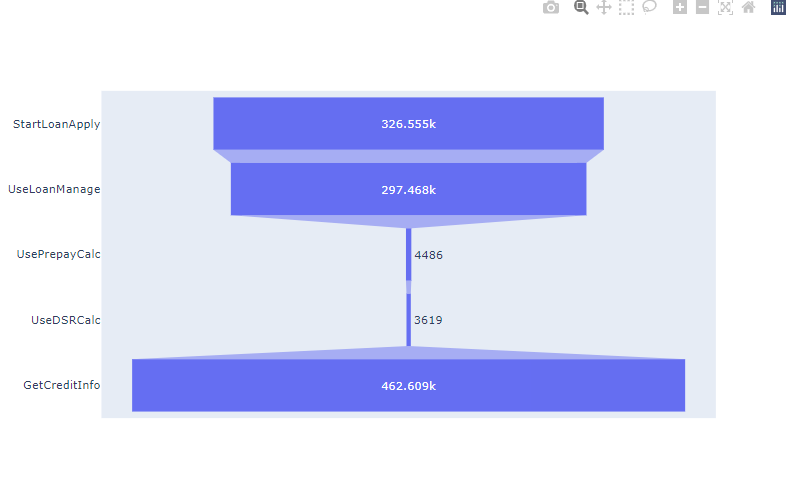

In [98]:
np.mean(funnel['UseLoanManage'] - funnel['StartLoanApply'])

Timedelta('0 days 19:54:19.140679419')

In [99]:
np.mean(funnel['StartLoanApply'] - funnel['GetCreditInfo'])

Timedelta('2 days 22:36:50.205554841')

#4.세션잡기

In [78]:
relog = log.sort_values(by = ['user_id', 'timestamp'])

In [83]:
sample = relog[relog['event'].isin(['OpenApp', 'GetCreditInfo', 'UseLoanManage', 'UsePrepayCalc', 'ViewLoanApplyIntro', 'StartLoanApply','EndLoanApply', 'CompleteIDCertification', 'UseDSRCalc'])]

In [85]:
sample = sample[['user_id', 'event', 'timestamp']]